In [5]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from urllib.request import urlopen

In [6]:
class CFG:
    epochs = 20
    batch_size = 32
    classes = [
        "ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam",
        "BandMarching", "BaseballPitch", "Basketball", "BasketballDunk", "BenchPress",
        "Biking", "Billiards", "BlowDryHair", "BlowingCandles", "BodyWeightSquats",
        "Bowling", "BoxingPunchingBag", "BoxingSpeedBag", "BreastStroke", "BrushingTeeth",
        "CleanAndJerk", "CliffDiving", "CricketBowling", "CricketShot", "CuttingInKitchen",
        "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", "FloorGymnastics",
        "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", "HammerThrow",
        "Hammering", "HandstandPushups", "HandstandWalking", "HeadMassage", "HighJump",
        "HorseRace", "HorseRiding", "HulaHoop", "IceDancing", "JavelinThrow",
        "JugglingBalls", "JumpingJack", "JumpRope", "Kayaking", "Knitting",
        "LongJump", "Lunges", "MilitaryParade", "Mixing", "MoppingFloor",
        "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingCello", "PlayingDaf",
        "PlayingDhol", "PlayingFlute", "PlayingGuitar", "PlayingPiano", "PlayingSitar",
        "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps",
        "Punch", "PushUps", "Rafting", "RockClimbingIndoor", "RopeClimbing",
        "Rowing", "SalsaSpin", "ShavingBeard", "Shotput", "SkateBoarding",
        "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", "SoccerPenalty",
        "StillRings", "SumoWrestling", "Surfing", "Swing", "TableTennisShot",
        "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", "Typing",
        "UnevenBars", "VolleyballSpiking", "WalkingWithDog", "WallPushups", "WritingOnBoard",
        "YoYo"
    ]
    videos_per_class = 10

In [7]:
data_dir='/kaggle/input/ucf101/UCF101/UCF-101'

In [4]:
import os
classes=os.listdir(data_dir)
classes

['HorseRace',
 'StillRings',
 'ApplyLipstick',
 'HammerThrow',
 'VolleyballSpiking',
 'Biking',
 'PlayingCello',
 'BodyWeightSquats',
 'TaiChi',
 'Punch',
 'BreastStroke',
 'Billiards',
 'BoxingPunchingBag',
 'BasketballDunk',
 'PoleVault',
 'ThrowDiscus',
 'BaseballPitch',
 'Knitting',
 'SumoWrestling',
 'HorseRiding',
 'Mixing',
 'BrushingTeeth',
 'HighJump',
 'Skijet',
 'SkateBoarding',
 'MilitaryParade',
 'IceDancing',
 'CricketShot',
 'Fencing',
 'JugglingBalls',
 'Swing',
 'RockClimbingIndoor',
 'PlayingFlute',
 'SalsaSpin',
 'CricketBowling',
 'Typing',
 'ApplyEyeMakeup',
 'PlayingTabla',
 'BalanceBeam',
 'FloorGymnastics',
 'HeadMassage',
 'FrisbeeCatch',
 'Rowing',
 'Hammering',
 'CuttingInKitchen',
 'BenchPress',
 'PushUps',
 'Nunchucks',
 'Archery',
 'LongJump',
 'BlowingCandles',
 'WallPushups',
 'PlayingViolin',
 'PullUps',
 'PlayingPiano',
 'PlayingDhol',
 'FrontCrawl',
 'HulaHoop',
 'CliffDiving',
 'BandMarching',
 'ParallelBars',
 'RopeClimbing',
 'YoYo',
 'TrampolineJu

In [5]:
len(classes)

101

In [8]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


In [9]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=0.1)


In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

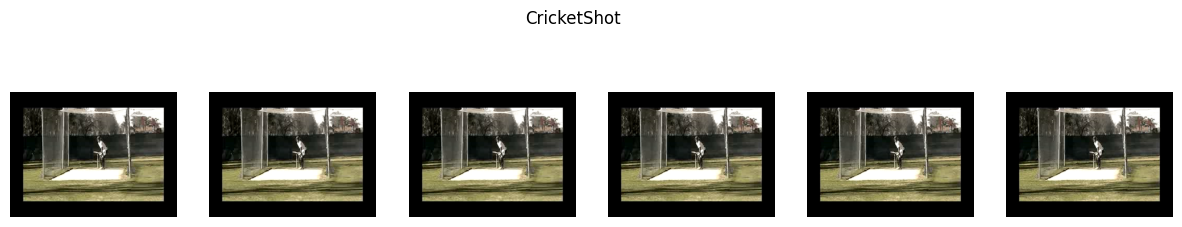

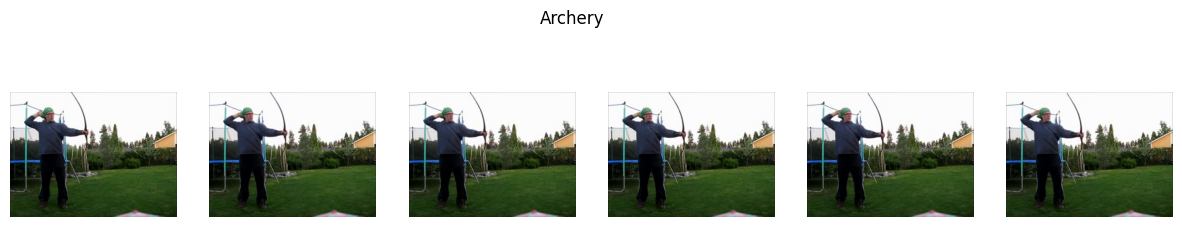

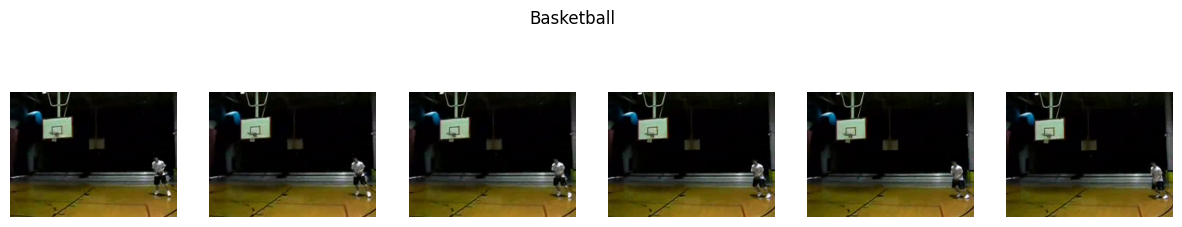

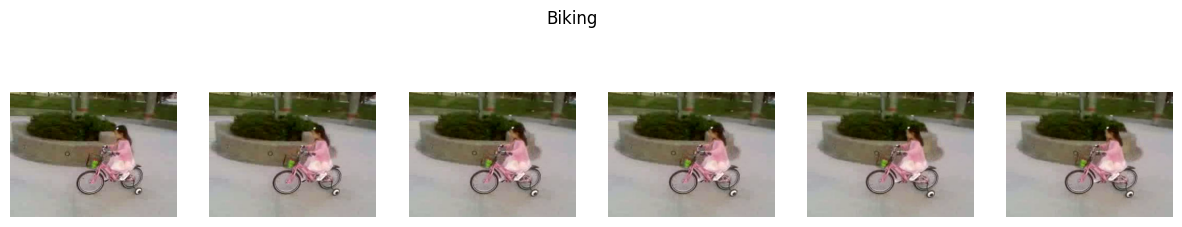

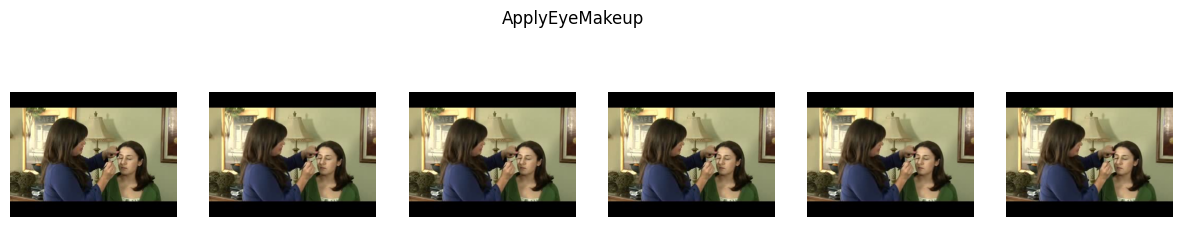

In [9]:
import cv2
import os
import matplotlib.pyplot as plt

# Set your UCF101 path
ucf101_dir = '/kaggle/input/ucf101/UCF101/UCF-101'

# Choose a few classes to preview
selected_classes = ['CricketShot', 'Archery', 'Basketball', 'Biking', 'ApplyEyeMakeup']

# Number of frames to display per video
frames_to_show = 6

def show_video_frames(video_path, title, num_frames=6):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    for _ in range(num_frames):
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    
    # Plot frames
    plt.figure(figsize=(15, 3))
    for i, frame in enumerate(frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Loop over each class and show frames
for class_name in selected_classes:
    class_path = os.path.join(ucf101_dir, class_name)
    if not os.path.exists(class_path):
        print(f"[!] Class folder '{class_name}' not found in {ucf101_dir}")
        continue
    
    # Pick the first video in the class
    video_list = os.listdir(class_path)
    if not video_list:
        print(f"[!] No videos found in {class_path}")
        continue

    video_path = os.path.join(class_path, video_list[0])
    show_video_frames(video_path, title=class_name, num_frames=frames_to_show)

In [10]:
def save_model(model, filepath):
    model.save(filepath)

In [26]:
def classify_video_url(model, video_url, n_frames=10):
    # Download video from URL
    video = urlopen(video_url)
    with open('temp_video.avi', 'wb') as f:
        f.write(video.read())

    # Create frames from the downloaded video
    video_frames = frames_from_video_file('temp_video.avi', n_frames=n_frames)

    # Predict using the model
    predictions = model.predict(np.expand_dims(video_frames, axis=0))

    # Classify the video based on predictions
    predicted_class = np.argmax(predictions)
    predicted_class_name = CFG.classes[predicted_class]

    print(f"Predicted Class: {predicted_class_name}")
    return predicted_class_name

In [11]:
# Load UCF101 dataset
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")[:CFG.videos_per_class]
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

MODEL 1

In [12]:
# Create features
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames=10))
features = np.array(features)

  0%|          | 0/1010 [00:00<?, ?it/s]

In [13]:
# Split dataset
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

In [14]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [15]:
# Clean up memory
del train_features
del val_features
gc.collect()

41

In [17]:
# Display shape of a batch
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


In [ ]:
# Build model
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(CFG.classes)),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
efficient_net_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling3D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [20]:
# Train model
history = efficient_net_model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.weights.h5",
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

Epoch 1/20


I0000 00:00:1746766026.344726     124 service.cc:148] XLA service 0x7d1cb8004380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746766026.346558     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746766026.346597     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746766046.405870     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746766101.730263     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 393s 6s/step - accuracy: 0.0358 - loss: 4.5973 - val_accuracy: 0.2228 - val_loss: 3.8493
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 820ms/step - accuracy: 0.6279 - loss: 3.1640 - val_accuracy: 0.4455 - val_loss: 3.0768
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 820ms/step - accuracy: 0.8004 - loss: 2.3165 - val_accuracy: 0.5446 - val_loss: 2.5362
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 826ms/step - accuracy: 0.8814 - loss: 1.7207 - val_accuracy: 0.5743 - val_loss: 2.1857
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 828ms/step - accuracy: 0.9205 - loss: 1.3258 - val_accuracy: 0.6040 - val_loss: 1.9584
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step - accuracy: 0.9371 - loss: 1.0598 - val_accuracy: 0.6238 - val_loss: 1.8019
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 835ms/step - accuracy: 0.9551 - loss: 0.8626 - val_accuracy: 0.6485 - val_loss: 1.6898
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 841ms/step - accuracy: 0.9701 - loss: 0.7220 - val_accuracy: 0.6733 

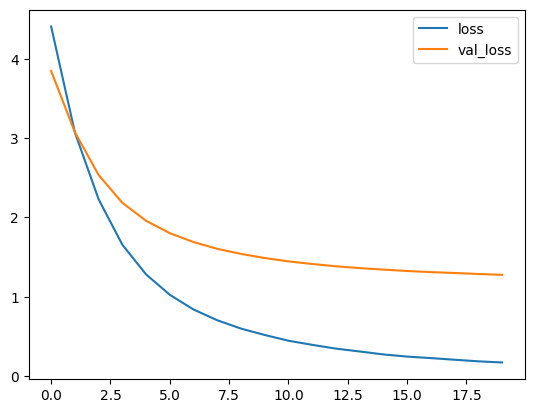

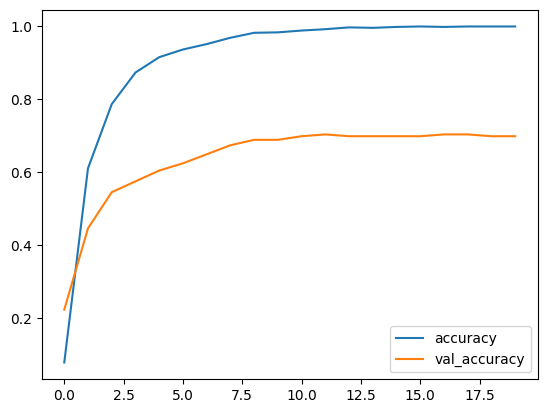

In [21]:
# Plot training history
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [22]:
# Evaluate model on validation set
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.7013 - loss: 1.2749
Validation Loss: 1.2760530710220337 Validation Accuracy: 0.698019802570343


In [23]:
# Plot confusion matrix
val_predictions = np.argmax(efficient_net_model.predict(valid_ds), axis=1)
plot_confusion_matrix(val_targets, val_predictions, CFG.classes)

7/7 ━━━━━━━━━━━━━━━━━━━━ 104s 9s/step


In [24]:
# Test classifying a video from a URL
video_url_to_classify = "https://www.engr.colostate.edu/me/facil/dynamics/files/drop.avi"  
classify_video_url(efficient_net_model, video_url_to_classify)

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step
Predicted Class: Mixing


'Mixing'

### Testing

In [25]:
# Save the model
save_model(efficient_net_model, "Video_Classification_Model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


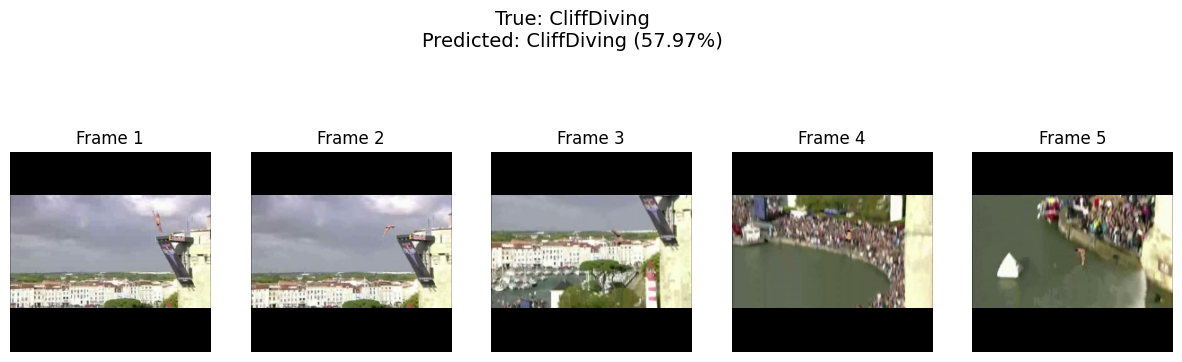

GIF saved as animation.gif for video: /kaggle/input/ucf101/UCF101/UCF-101/CliffDiving/v_CliffDiving_g12_c01.avi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


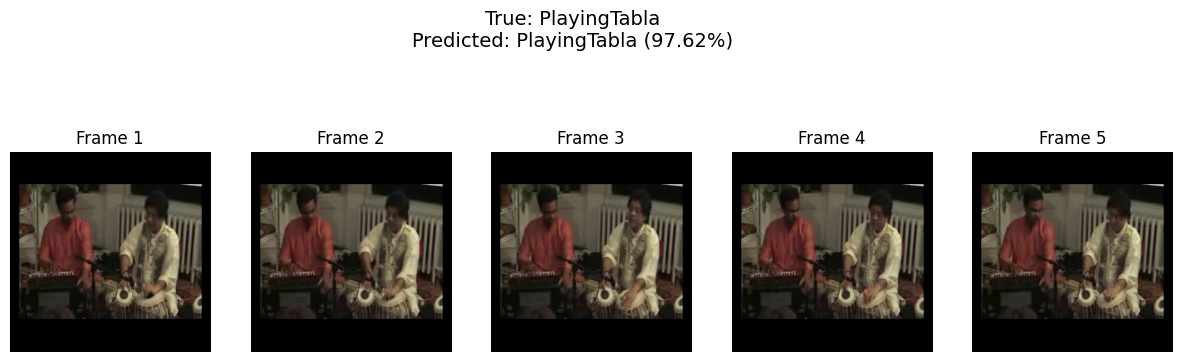

GIF saved as animation.gif for video: /kaggle/input/ucf101/UCF101/UCF-101/PlayingTabla/v_PlayingTabla_g10_c02.avi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


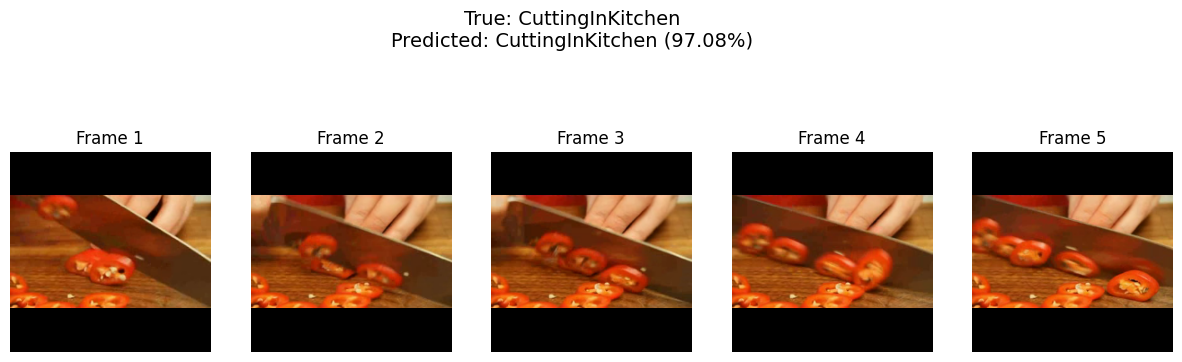

GIF saved as animation.gif for video: /kaggle/input/ucf101/UCF101/UCF-101/CuttingInKitchen/v_CuttingInKitchen_g16_c02.avi




In [36]:
import random
import matplotlib.pyplot as plt

def visualize_and_classify_random_videos(model, file_paths, targets, num_videos=3):
    # Select random videos
    random_indices = random.sample(range(len(file_paths)), num_videos)
    
    for idx in random_indices:
        video_path = file_paths[idx]
        true_class_idx = targets[idx]
        true_class = CFG.classes[true_class_idx]
        
        # Get frames from video
        frames = frames_from_video_file(video_path, n_frames=10)
        
        # Make prediction
        predictions = model.predict(np.expand_dims(frames, axis=0))
        predicted_class_idx = np.argmax(predictions)
        predicted_class = CFG.classes[predicted_class_idx]
        confidence = np.max(tf.nn.softmax(predictions)) * 100
        
        # Display frames and prediction
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"True: {true_class}\nPredicted: {predicted_class} ({confidence:.2f}%)", fontsize=14)
        
        # Display first 5 frames
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(frames[i])
            plt.axis('off')
            plt.title(f"Frame {i+1}")
        
        plt.show()
        
        # Also create a GIF for the video
        to_gif(frames)
        print(f"GIF saved as animation.gif for video: {video_path}")
        print("\n" + "="*80 + "\n")

# Call the function with your model and data
visualize_and_classify_random_videos(efficient_net_model, file_paths, targets, num_videos=3)

In [16]:
from tensorflow.keras.models import load_model
efficient_net_model=load_model('/kaggle/working/Video_Classification_Model.h5')

I0000 00:00:1746769617.948751    4676 service.cc:148] XLA service 0x78983c0054d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746769617.955013    4676 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746769617.955048    4676 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746769621.646513    4676 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746769631.594966    4676 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


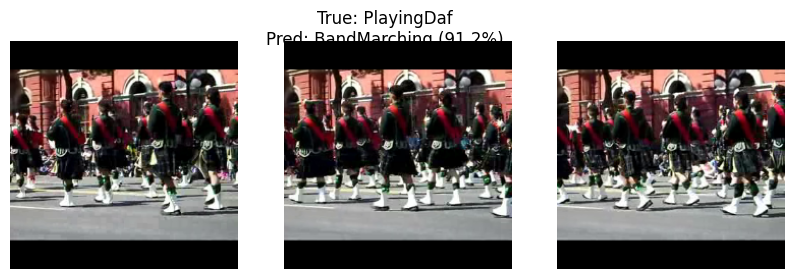

Sample GIF saved as kaggle_sample.gif (overwritten for each sample)


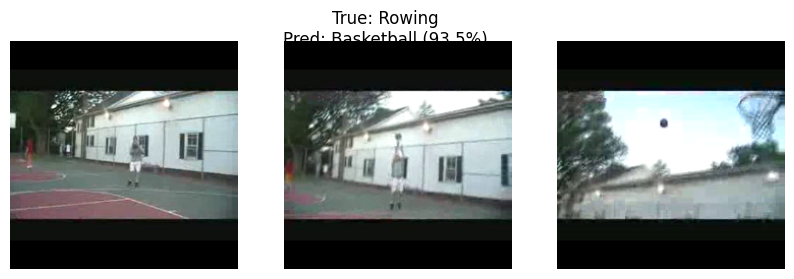

Sample GIF saved as kaggle_sample.gif (overwritten for each sample)


In [18]:
import gc
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def kaggle_safe_visualize(model, val_ds, val_targets, file_paths, num_samples=2):
    """Memory-optimized visualization for Kaggle environment"""
    try:
        # Get the file paths in validation set order
        val_file_paths = []
        for batch in val_ds.unbatch().as_numpy_iterator():
            val_file_paths.append(file_paths[batch[1]])  # Assuming batch is (features, index)
        
        # Process one sample at a time
        for i in random.sample(range(len(val_targets)), min(num_samples, len(val_targets))):
            try:
                # Clear memory before each sample
                gc.collect()
                
                # Load only this specific video
                frames = frames_from_video_file(val_file_paths[i], n_frames=5)  # Reduced frames
                
                # Predict
                pred = model.predict(np.expand_dims(frames, axis=0), verbose=0)
                pred_class = CFG.classes[np.argmax(pred)]
                true_class = CFG.classes[val_targets[i]]
                confidence = np.max(tf.nn.softmax(pred)) * 100
                
                # Plot just 3 frames to save memory
                plt.figure(figsize=(10, 3))
                plt.suptitle(f"True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)")
                for j in range(min(3, len(frames))):
                    plt.subplot(1, 3, j+1)
                    plt.imshow(frames[j])
                    plt.axis('off')
                plt.show()
                
                # Save only one GIF and overwrite each time
                imageio.mimsave('kaggle_sample.gif', 
                               np.clip(frames[::2] * 255, 0, 255).astype(np.uint8),  # Skip frames
                               duration=0.2)
                print("Sample GIF saved as kaggle_sample.gif (overwritten for each sample)")
                
                # Explicit cleanup
                del frames, pred
                
            except Exception as e:
                print(f"Skipping sample {i} due to error: {str(e)}")
                
            finally:
                gc.collect()
                plt.close('all')
                
    except Exception as e:
        print(f"Visualization failed: {str(e)}")
    finally:
        gc.collect()

# Usage with maximum memory safety
kaggle_safe_visualize(
    efficient_net_model,
    valid_ds,
    val_targets,
    file_paths,
    num_samples=2  # Very conservative sample count
)

In [19]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
from base64 import b64encode

def show_video(video_path):
    """Display video in notebook"""
    video = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video).decode()
    display(HTML(f"""
    <video width="400" controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """))

def predict_video_class(model, video_path, class_names, n_frames=10):
    """Predict class for uploaded video"""
    # Display original video
    print("Input Video:")
    show_video(video_path)
    
    # Process video
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(total_frames // n_frames, 1)
    
    for i in range(n_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_step)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame.astype(np.float32) / 255.0)
        else:
            frames.append(np.zeros((224, 224, 3), dtype=np.float32))
    
    cap.release()
    frames = np.array(frames)
    
    # Show sample frames
    print("\nFrames used for prediction:")
    plt.figure(figsize=(15, 3))
    for i in range(min(5, len(frames))):
        plt.subplot(1, 5, i+1)
        plt.imshow(frames[i])
        plt.axis('off')
    plt.show()
    
    # Predict
    pred = model.predict(np.expand_dims(frames, axis=0))
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(tf.nn.softmax(pred)) * 100
    
    print("\nPrediction Result:")
    print(f"Class: {pred_class}")
    print(f"Confidence: {confidence:.2f}%")
    return pred_class, confidence



Input Video:



Frames used for prediction:


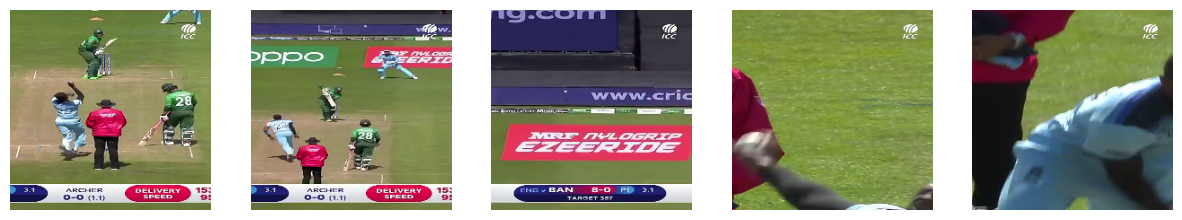

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step

Prediction Result:
Class: YoYo
Confidence: 31.87%


In [20]:
# Usage (after uploading video)
video_path = '/kaggle/input/testing-video/Hits the bails and goes for six  cricket cricketshorts shorts.mp4'  # For Method 1
# OR
# video_path = '/kaggle/input/your-dataset/your_video.mp4'  # For Method 2

pred_class, confidence = predict_video_class(
    efficient_net_model,
    video_path,
    CFG.classes,
    n_frames=8  # Reduced for Kaggle memory limits
)

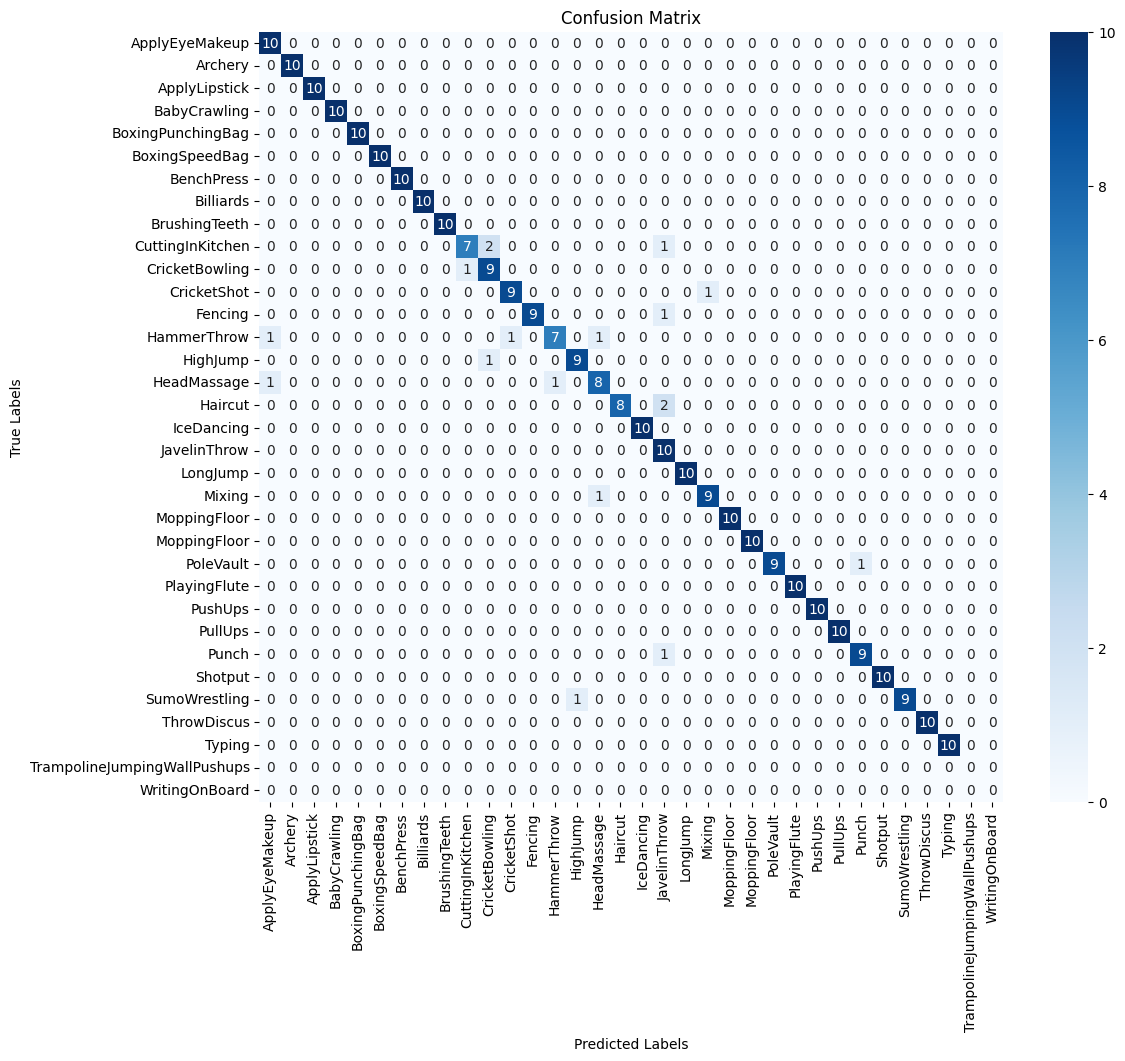

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(con_mat_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [94]:
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k(probs, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

In [95]:
save_dir = '/kaggle/working/sample_gifs'
files = [file for file in os.listdir(save_dir) if file.endswith('.gif')]
for file_name in files:
  file_name = save_dir+'/'+file_name
  video = load_gif(file_name, image_size=(224, 224))
  media.show_video(video.numpy(), fps=23)
  outputs = predict_top_k(model, video)
  for label, prob in outputs:
    print(label, prob)

1/1 [==============================] - 21s 21s/step
Archery 0.98361707
ApplyEyeMakeup 0.015291223
HammerThrow 0.0009812367
JavelinThrow 5.897614e-05
BrushingTeeth 2.4502475e-05


1/1 [==============================] - 16s 16s/step
ApplyLipstick 0.9994554
MoppingFloor 0.0002415836
HammerThrow 0.00013973509
JavelinThrow 6.034541e-05
Mixing 3.6500045e-05


1/1 [==============================] - 10s 10s/step
Mixing 0.9994653
HammerThrow 0.00021810495
CricketShot 0.00014887755
HeadMassage 4.815045e-05
Billiards 3.0096371e-05


2025-04-29 09:05:32.225590: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-29 09:05:32.379961: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 [==============================] - 12s 12s/step
BoxingSpeedBag 0.9997645
Typing 5.0681203e-05
Archery 4.88729e-05
ApplyLipstick 3.0124596e-05
PlayingFlute 2.5566851e-05


2025-04-29 09:05:45.784800: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-29 09:05:45.930336: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 [==============================] - 11s 11s/step
PoleVault 0.9999795
ApplyLipstick 1.0363653e-05
JavelinThrow 3.2644257e-06
HammerThrow 1.493174e-06
BoxingPunchingBag 1.2155382e-06


In [41]:
from tensorflow.keras import backend as K
K.clear_session()